In [27]:
import numpy as np
import sympy as sp
import pandas as pd
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


from sympy import solve, Eq, symbols, re

lam1,lam2 ,p, coeffIAT2 = symbols('lam1 lam2 p coeffIAT2')

coeffIAT2 = 16
coeffST2_arr = [1.21, 4,  25, 64]

In [9]:
def compute_kurtosis_H2(lam1 , lam2, p) :
    
    moment1 = (p/lam1+ (1-p)/lam2)
    moment2 = (2*p/lam1**2 + 2*(1-p)/lam2**2)
    moment3 = (6*p/lam1**3 + 6*(1-p)/lam2**3)
    moment4 = (24*p/lam1**4 + 24*(1-p)/lam2**4)
    
    kurtosis_num = moment4 - 4*moment1*moment3 + 6*(moment1**2)*moment2 - 3*(moment1**4) 
    kurtosis_deno = (moment2 - moment1**2)**2

    return (kurtosis_num / kurtosis_deno) 

In [10]:
compute_kurtosis_H2(13.12377,0.071480, 0.93360)

90.91789706408342

In [11]:
def calculatecoeff_var(lam1, lam2, p) :
    dist_mean =  p/lam1+ (1-p)/lam2
    dist_var = (2*p/lam1**2 + 2*(1-p)/lam2**2) - dist_mean**2
    dist_sd = abs(np.sqrt(dist_var))
    
    if (dist_sd / dist_mean) >= 1 :
        return(dist_sd/dist_mean)
    else :
        print("Please check your inputs. Coefficient of variance < 1")
        return -100

In [12]:
calculatecoeff_var(13.12377,0.071480, 0.93360)


4.999859835679422

In [13]:
#Implementing the Tarasov H2/H2/1 RT
def Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    for k in range(min(len(p_arr), len(q_arr))) : 
        a_0 = (lam1_arr[k]*lam2_arr[k])
        a_1 = p_arr[k]*lam1_arr[k] + (1-p_arr[k])*lam2_arr[k]
        b_0 = (mu1_arr[k]*mu2_arr[k])
        b_1 = q_arr[k]*mu1_arr[k] + (1-q_arr[k])*mu2_arr[k]

        c_0 = a_0*b_1 - a_1*b_0 - a_0*(mu1_arr[k]+mu2_arr[k]) + b_0*(lam1_arr[k] + lam2_arr[k])
        c_1 = -a_1*b_1 -a_0 - b_0  + (lam1_arr[k] + lam2_arr[k])*(mu1_arr[k] + mu2_arr[k])
        c_2 = lam1_arr[k] + lam2_arr[k] - mu1_arr[k] - mu2_arr[k]
        
        x = symbols('x')
        expr = x**3-c_2*x**2-c_1*x-c_0


        sol = solve(expr)
        #print(sol)
        
        #calculate wait time in queue Wq
        
        Wq = (-1/re(sol[0])) + (-1/re(sol[1])) - (1/mu1_arr[k]) - (1/mu2_arr[k]) 
        
        #calculate response time in queue W

        W = Wq + (q_arr[k]/mu1_arr[k]+ (1-q_arr[k])/mu2_arr[k])
        WTarasov_arr.append(W)

        if k == 0 :
            print("In order lam1 lam2 p", lam1_arr[k], lam2_arr[k], p_arr[k])
            print("In order mu1 mu2 q", mu1_arr[k], mu2_arr[k], q_arr[k])
            print("RT ", W)

    return WTarasov_arr

In [15]:
def MAM_1server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    
    
    mu_CV_arr = []
    lam_CV_arr = []
    for k in range(min(len(p_arr), len(q_arr))) :  
        
            
        if calculatecoeff_var(lam1_arr[k], lam2_arr[k], p_arr[k]) >=1 : 
            lam_CV_arr.append(calculatecoeff_var(lam1_arr[k], lam2_arr[k], p_arr[k]))

        if calculatecoeff_var(mu1_arr[k], mu2_arr[k], q_arr[k]) >=1 :
            mu_CV_arr.append(calculatecoeff_var(mu1_arr[k], mu2_arr[k], q_arr[k]))
        else :
            continue

        lam1 = lam1_arr[k]
        lam2 = lam2_arr[k]
        p = p_arr[k]

        mu1 = mu1_arr[k]
        mu2 = mu2_arr[k]
        q = q_arr[k]

        

        b1 = mu1*(1-q)
        b2 = mu2*(1-q)
        b3 = mu1*q
        b4 = mu2*q
        f1 = lam1*(1-p)
        f2 = lam2*(1-p)
        f3 = lam1*p
        f4 = lam2*p

        #Initializing forward, backward and initial arrays
        L_0 = np.transpose(np.array([[-(lam1), 0],
                       [0, -(lam2)]]))
    #     print("L :", L_0)
        #F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
        #             [lam2*(1-p)*(1-q), lam2*p*(1-q), lam2*p*q, lam2*(1-p)*q]])
        F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
                      [lam2*(p)*(q), lam2*(1-p)*(q), lam2*(p)*(1-q), lam2*(1-p)*(1-q)]])
                       #[lam2*(1-p)*(1-q), lam2*(p)*(1-q), lam2*(1-p)*(q), lam2*(p)*(q)]])
    #     print("F_0 :",F_0)
        B_0 = np.array([[mu1, 0],
                       [mu1, 0],
                       [0, mu2],
                       [0, mu2]])
    #     print(B_0)
        L = np.array([[-(lam1 + mu1), 0, 0, 0],
                     [0, -(lam2 + mu1), 0, 0],
                     [0, 0, -(lam1 + mu2), 0],
                     [0, 0, 0, -(lam2 + mu2)]])
        L1 = np.array([[-(lam2 + mu2), 0, 0, 0],
                     [0, -(lam2 + mu2), 0, 0],
                     [0, 0, -(lam1 + mu2), 0],
                     [0, 0, 0, -(lam2 + mu2)]])
    #     print("L :",L)
    #     print(L1)
        F = np.array([[f3, f1, 0, 0],
                     [f4, f2, 0, 0],
                     [0, 0, f3, f1],
                     [0, 0, f4, f2]])
    #     print("F :",F)
        B = np.array([[b3, 0, b1, 0],
                     [0, b3, 0, b1],
                     [b4, 0, b2, 0],
                     [0, b4, 0, b2]])
        B1 = np.array([[mu1*(q), 0, mu1*(1-q), 0],
                     [0, mu1*(q), 0, mu1*(1-q)],
                     [mu2*(q), 0, mu2*(1-q), 0],
                     [0, mu2*(q), 0, mu2*(1-q)]])
    #     print("B :",B)
    #     print(B1)
        R_0 = np.zeros((4, 4))
    #     print(R_0)

        # Computing matrix R
        R_prev = R_0
        n = 0
        flag = 0

        while flag == 0 :
            diff = []
            if n > 0:
                R_prev = R

            R_2 = np.matmul(R_prev,R_prev)
            R_mid = -(np.matmul(R_2,B) + F)
            #print(R_mid)
            R = np.matmul(R_mid, np.linalg.inv(L))

            for (i,j) in zip(R_prev, R) :
                for (k,l) in zip(i,j) :
                    diff.append(abs(k-l))

            max = np.max(diff)
            #print("Max is", max)
            if (max < 10**-11) :

                flag =1
                break
            n += 1
    #     print(R,n)

        #Computing steady state distribution for state 0 and 1

        #Creating (I - R)^-1 = psi
        I = np.identity(4)
        psi_full = np.linalg.inv(I - R)
        psi = np.matmul(psi_full,np.ones((4,1), dtype=np.int64))
        psi = np.vstack([np.ones((2,1), dtype=np.int64), psi])
    #     print(psi)

        #Creating L + RB
        RB = np.matmul(R, B)
        LRB = np.add(L, RB)
    #     print(LRB)

        #Creating stacked version of [F_0  L+RB]T = phi
        phi = np.vstack([F_0, LRB])
    #     print(phi)

        #Solving for pi_0 and pi_1
        A = np.array([0, -(lam2), 0, 0, mu2, mu2])
        A = A[..., None] 

        A = np.hstack([psi,A, phi])
        b = np.array([1, 0, 0, 0, 0, 0])
    #     print(A,b)
        """
        steady_pi = np.linalg.solve(np.transpose(A), b)
        print(steady_pi)
        """
        steady_pi = np.matmul(b, np.linalg.inv(A)) 
    #     print(steady_pi)
    #     print(b.shape)

        #Average arrival rate 

        lam_avg = p/(lam1) + (1-p)/(lam2)
        lam_avg
        #[0.19573734 0.04410614 0.02985372 0.02985372 0.05228525 0.05228525]

        #Computing avg response time W

        pi_1 = [steady_pi[2], steady_pi[3], steady_pi[4], steady_pi[5]]
    #     print(pi_1)

        squareI_R = np.matmul((I - R), (I - R))
        W_num = np.matmul(np.linalg.inv(squareI_R), np.ones((4,1), dtype=int))
    #     print(W_num)
        W_num = np.dot(pi_1, W_num)

        W = W_num * lam_avg
        #print("The mean response time is: ", W)
        WTarasov_arr.append(abs(W))


    
    
        

    return WTarasov_arr
    
    

# dummy

Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 10.575 0.09785 0.8996
In order mu1 mu2 q 1.263171946034705 0.6649030350546067 0.707516432078946
RT  85.1663808148868
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 10.575 0.09785 0.8996
In order mu1 mu2 q 1.6457033450812846 0.20733775746235994 0.9069230488357823
RT  97.7234280196785
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 10.575 0.09785 0.8996
In order mu1 mu2 q 2.351842031772774 0.045710572843143844 0.9732047046032433
RT  192.216778325103
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 10.575 0.09785 0.8996
In order mu1 mu2 q 2.3857823653765036 0.018105825725388474 0.9894028033049984
RT  367.689681140626
False
False


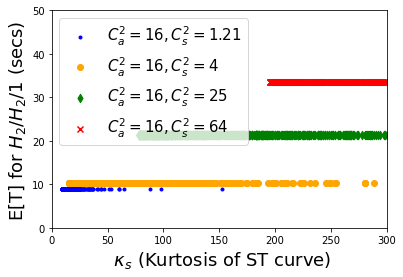

In [31]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['q', 'mu1', 'mu2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= [0.8996]*1000
    lam1_arr = [10.5750]*1000
    lam2_arr = [0.09785]*1000
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 1000 :
        #p = np.random.rand()
        #lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        #lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        q = np.random.rand()
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(mu1, mu2, q) >= 1 :
            
            lam_kurt_arr.append(compute_kurtosis_H2(lam1_arr[0], lam2_arr[0], p_arr[0]))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    
    store_df = pd.DataFrame({'q' : q_arr,
                             'mu1' : mu1_arr, 
                             'mu2' : mu2_arr,
                            'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        W_exact = np.array(W_exact) / 9.5
        plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 16, C_s^2 = 1.21$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        W_exact = np.array(W_exact) / 9.5
        plt.scatter(mu_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 16, C_s^2 = 4$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    if coeffST2 == 25 :
        W_exact = np.array(W_exact) / 9
        plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 16, C_s^2 = 25$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
    
    elif coeffST2 == 64 :
        W_exact = np.array(W_exact) / 11
        plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 16, C_s^2 = 64$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
    
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r" $\kappa_s$ (Kurtosis of ST curve)", fontsize = 18)
    plt.ylabel("E[T] for $H_2/H_2/1$ (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 50)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_1_fixedmean_CVa2D_load0.4.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




#final_df.to_csv('DetailsH2_H2_1_fixedmean_CVa2D_load0.4MAM.csv', index= False)

In [20]:
import pandas as pd

df = pd.read_csv("DetailsH2_H2_1_fixedmean_CVa2D_load0.2.csv")

df_25 = df[(df['coeffST_sq'] == 64) & (df['mu_kurt'] > 250)]
df_25.sort_values(by = 'mu_kurt')

df_25.head(50)

,q,mu1,mu2,coeffIAT_sq,coeffST_sq,lam_kurt,mu_kurt,Response time
6000,0.991740,2.049998,0.016000,16,64.0,75.054064,726.744838,14.467197
6002,0.987351,2.741587,0.019768,16,64.0,75.054064,475.847362,15.156936
6004,0.998119,1.322184,0.007676,16,64.0,75.054064,3150.606849,12.982654
6007,0.992595,1.940877,0.015156,16,64.0,75.054064,809.904623,14.311051
6009,0.992720,1.925359,0.015028,16,64.0,75.054064,823.742186,14.287386
6010,0.977459,6.770520,0.026344,16,64.0,75.054064,267.074932,16.283561
6011,0.977214,6.993919,0.026486,16,64.0,75.054064,264.193082,16.306436
6012,0.992631,1.936342,0.015119,16,64.0,75.054064,813.888797,14.304175
6013,0.995546,1.601034,0.011777,16,64.0,75.054064,1340.641975,13.691113
6014,0.991532,2.077639,0.016199,16,64.0,75.054064,708.956460,14.504084


# 2D plots fixed IAT (take specific values of p, lam1, lam2), changing ST

Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.07672 0.019586 0.918779
In order mu1 mu2 q 1.1646783203806448 0.5738529534298457 0.8400523305151706
RT  4.16745609487984
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.07672 0.019586 0.918779
In order mu1 mu2 q 1.1696070039925186 0.0881525262180007 0.9861748356741056
RT  4.83509308825630
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.07672 0.019586 0.918779
In order mu1 mu2 q 4.368328700835024 0.06037700242382324 0.9527920449503755
RT  10.1916798140814
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.07672 0.019586 0.918779
In order mu1 mu2 q 2.0499977282380026 0.015999983383664984 0.9917404302698
RT  14.4671972507951
False
False


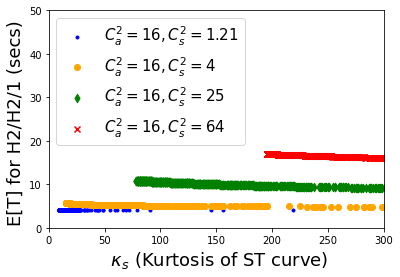

In [23]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['q', 'mu1', 'mu2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= [0.918779]*1000
    lam1_arr = [1.07672]*1000
    lam2_arr = [0.019586]*1000
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 1000 :
        #p = np.random.rand()
        #lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        #lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        q = np.random.rand()
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(mu1, mu2, q) >= 1 :
            
            lam_kurt_arr.append(compute_kurtosis_H2(lam1_arr[0], lam2_arr[0], p_arr[0]))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'q' : q_arr,
                             'mu1' : mu1_arr, 
                             'mu2' : mu2_arr,
                            'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 16, C_s^2 = 1.21$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 16, C_s^2 = 4$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 16, C_s^2 = 25$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 16, C_s^2 = 64$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r" $\kappa_s$ (Kurtosis of ST curve)", fontsize = 18)
    plt.ylabel("E[T] for H2/H2/1 (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 50)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_1_fixedmean_CVa2D_load0.2.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




final_df.to_csv('DetailsH2_H2_1_fixedmean_CVa2D_load0.2.csv', index= False)

In [7]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['q', 'mu1', 'mu2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= [0.918779]*1000
    lam1_arr = [1.07672]*1000
    lam2_arr = [0.019586]*1000
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 1000 :
        #p = np.random.rand()
        #lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        #lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        q = np.random.rand()
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(mu1, mu2, q) >= 1 :
            
            lam_kurt_arr.append(compute_kurtosis_H2(lam1_arr[0], lam2_arr[0], p_arr[0]))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'q' : q_arr,
                             'mu1' : mu1_arr, 
                             'mu2' : mu2_arr,
                            'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 16, C_s^2 = 1.21$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 16, C_s^2 = 4$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 16, C_s^2 = 25$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 16, C_s^2 = 64$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r" $\kappa_s$ (Kurtosis of ST curve)", fontsize = 18)
    plt.ylabel("E[T] for H2/H2/3 (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 50)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_2_fixedmean_CVa2D_load0.4.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




#final_df.to_csv('DetailsH2_H2_1_fixedmean_CVa2D_load0.2.csv', index= False)

Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.07672 0.019586 0.918779
In order mu1 mu2 q 1.0539095554027946 0.32757815013293423 0.9756865911273995
RT  4.14850946107693


KeyboardInterrupt: 

# 2D plots fixed ST (take specific values of q, mu1, mu2), changing IAT

In [24]:
coeffST2 = 16
coeffIAT2_arr = [ 1.21, 4, 25, 64]

Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 0.29804946948413485 0.15160960896064318 0.4924455105956774
In order mu1 mu2 q 3.82658 0.08965 0.93218
RT  3.20589114996340
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 0.4506810409042159 0.054101723744536936 0.8290092821768096
In order mu1 mu2 q 3.82658 0.08965 0.93218
RT  4.10308354301795
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 0.29874030857733697 0.005361041640999903 0.9909783859054506
In order mu1 mu2 q 3.82658 0.08965 0.93218
RT  4.40770497220405
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.902076533528176 0.005524654142891281 0.9752092619382436
In order mu1 mu2 q 3.82658 0.08965 0.93218
RT  27.5832358130818
False
False


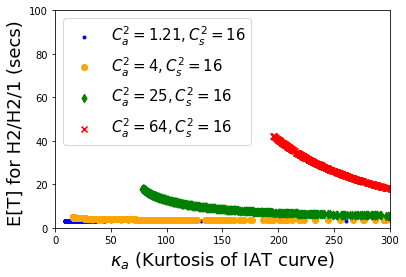

In [25]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['p', 'lam1', 'lam2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= [0.93218]*1000
    mu1_arr = [3.82658]*1000
    mu2_arr = [0.08965]*1000
    mu_kurt_arr = []
    

    p_arr = []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
   
    

    while i < 1000 :
        p = np.random.rand()
        lam2 = (2*p + math.sqrt(2)*math.sqrt(-p*(coeffIAT2 - 1)*(p - 1)) - 2)/(5*(coeffIAT2*p + p - 2))  
        lam1 = (2*p/5 + math.sqrt(2)*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1))/5)/(coeffIAT2*p - coeffIAT2 + p + 1)

       

        #q = np.random.rand()
        #mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        #mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if lam1 <= 0 or lam2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >= 1 :
            
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1_arr[0], mu2_arr[0], q_arr[0]))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'p' : p_arr,
                             'lam1' : lam1_arr, 
                             'lam2' : lam2_arr,
                            'coeffIAT_sq' : [coeffIAT2] * len(W_exact),
                            'coeffST_sq' : [16] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 1.21, C_s^2 = 16$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 4 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 4, C_s^2 = 16$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 25 :
        plt.scatter(lam_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 25, C_s^2 = 16$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 64 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 64, C_s^2 = 16$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r"$\kappa_a$ (Kurtosis of IAT curve)", fontsize = 18)
    plt.ylabel("E[T] for H2/H2/1 (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 100)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_1_fixedmean_CVs2D_load0.2.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




final_df.to_csv('DetailsH2_H2_1_fixedmean_CVs2D_load0.2.csv', index= False)

# Generating 3D data

In [9]:
coeffIAT2 = 16
coeffST2_arr = [ 1.21, 4, 25, 64]

Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.6392606119100096 0.016785804921381677 0.9407739649991741
In order mu1 mu2 q 1.0670923363174558 0.37453080307670183 0.9637170917020398
RT  2.36208250654581
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 1.0767200532182362 0.019586869007947726 0.9187793879923715
In order mu1 mu2 q 24.786728213640647 0.3901585814260334 0.6195942185107035
RT  5.63541440564801
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.3184549986577349 0.009450439578226388 0.9818861603387254
In order mu1 mu2 q 1.8634513790454947 0.03717788112886123 0.9824225162510845
RT  5.97850824911727
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.7763960608239278 0.0180141599732542 0.9315431259897625
In order mu1 mu2 q 3.512696278678649 0.02220429394064147 0.9840158215520084
RT  15.1192576426619
False
False


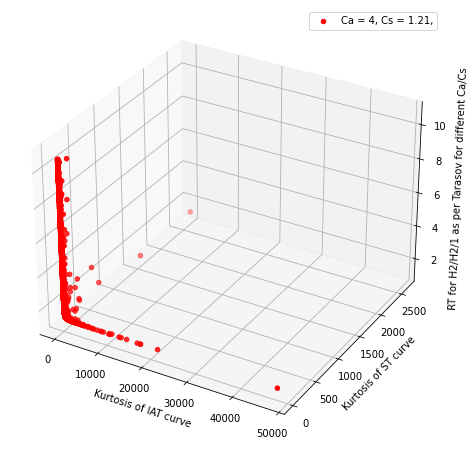

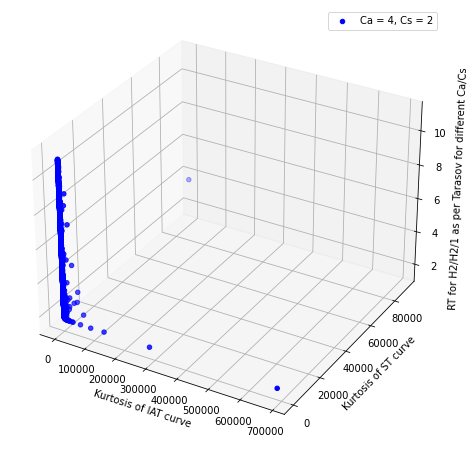

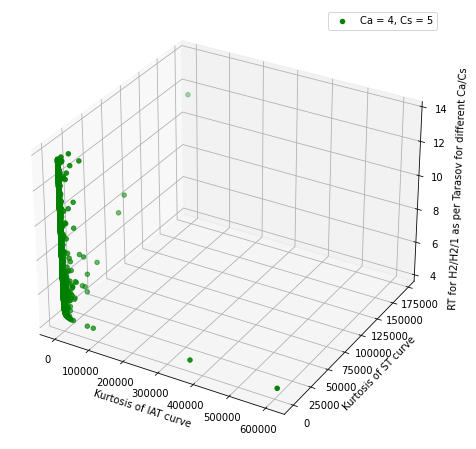

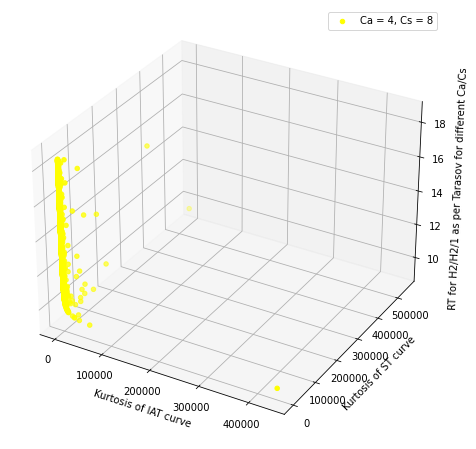

In [10]:
W_exact = []

final_df = pd.DataFrame(columns = ['coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = (2*p + math.sqrt(2)*math.sqrt(-p*(coeffIAT2 - 1)*(p - 1)) - 2)/(5*(coeffIAT2*p + p - 2))  
        lam1 = (2*p/5 + math.sqrt(2)*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1))/5)/(coeffIAT2*p - coeffIAT2 + p + 1)

        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()



final_df.to_csv('DetailsH2_H2_1_fixedmean_CVa.csv', index= False)

In [11]:
coeffST2 = 16
coeffIAT2_arr = [ 1.21, 4, 25, 64]

Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.2639046213314794 0.1395074949795382 0.6416648076601035
In order mu1 mu2 q 3.8265885330041183 0.08965895787981307 0.9321825640196206
RT  3.20070993679772
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 2.4276860101220947 0.07591086714381338 0.6404724804209914
In order mu1 mu2 q 3.5134821469302224 0.08707836933172658 0.9361225527096246
RT  4.63198486128259
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 0.32238559529990457 0.006133059617027142 0.9881329306875134
In order mu1 mu2 q 10.885900675800348 0.10800703435289051 0.9009317729955781
RT  4.73265799521828
Lengths for parameter vectors of IAT :  3000 3000 3000
In order lam1 lam2 p 15.8836181996814 0.006078714547078036 0.969977640997057
In order mu1 mu2 q 3.2080765072990767 0.0840574784417776 0.9405876399293323
RT  40.5054321016085
False
False


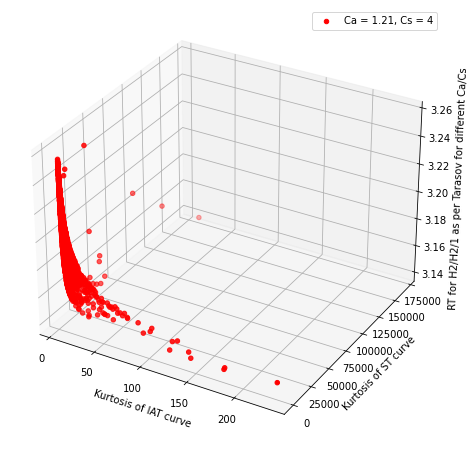

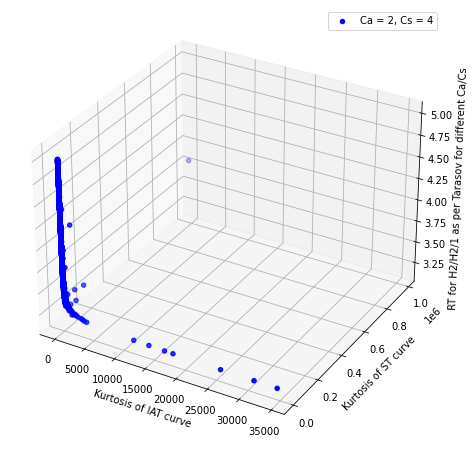

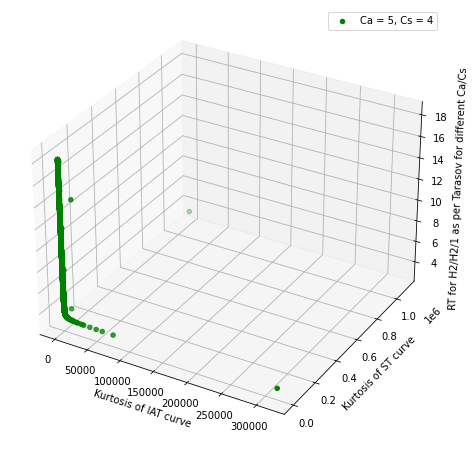

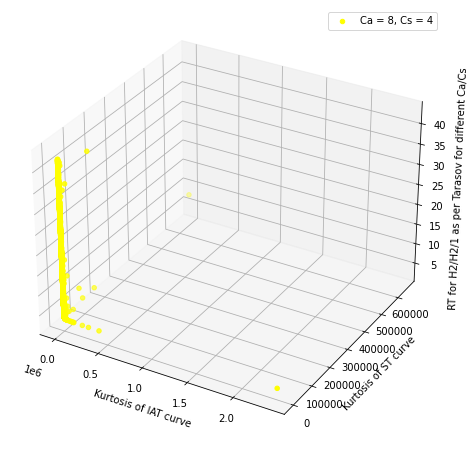

In [12]:
W_exact = []

final_df = pd.DataFrame(columns = ['coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])

for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 3000 :
        p = np.random.rand()
        lam2 = (2*p + math.sqrt(2)*math.sqrt(-p*(coeffIAT2 - 1)*(p - 1)) - 2)/(5*(coeffIAT2*p + p - 2))  
        lam1 = (2*p/5 + math.sqrt(2)*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1))/5)/(coeffIAT2*p - coeffIAT2 + p + 1)
        if lam1 <= 0 or lam2 <= 0 :
            continue
        #print("lam1 :",lam1, "lam2 :", lam2, "p :",p)

        q = np.random.rand()*0.5 + 0.5
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >=1 and calculatecoeff_var(mu1, mu2, q) >= 1 :
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            #if calculatecoeff_var(lam1, lam2, p) > 0  :
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'coeffIAT_sq' : [coeffIAT2] * len(W_exact),
                            'coeffST_sq' : [16] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 1.21, Cs = 4')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
    elif coeffIAT2 == 4 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 2, Cs = 4')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
    elif coeffIAT2 == 25 :
        #plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = 'Ca = 4, Cs = 5')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 5, Cs = 4')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
    elif coeffIAT2 == 64 :
        #plt.scatter(mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 8, Cs = 4')
        #ax1.set_xlim(150, 300)
        #ax1.set_ylim(0,100)
        #ax1.set_zlim(0,400)
        
    plt.legend()

    #plt.xlabel("Kurtosis of ST curve")
    #plt.ylabel("RT for H2/H2/1 as per Tarasov for Ca/Cs ")
    #plt.xlim(10, 250)
    #plt.ylim(0, 200)
    
    
    ax1.set_xlabel('Kurtosis of IAT curve')
    ax1.set_ylabel('Kurtosis of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.show()


final_df.to_csv('DetailsH2_H2_1_fixedmean_CVs.csv', index= False)

# Looking at the dataframe for #customers dist

In [56]:
import pandas as pd

df = pd.read_csv("DetailsH2_H2_1_fixedmean_CVa(constantIATparams).csv")

df_25 = df[(df['coeffST_sq'] == 25) & (df['mu_kurt'] > 140 )]
df_25.sort_values(by = 'mu_kurt')

df_25.head(50)

,q,mu1,mu2,coeffIAT_sq,coeffST_sq,lam_kurt,mu_kurt,Response time
4001,0.981849,1.890344,0.037767,16,25.0,54.451166,326.886405,38.395344
4003,0.965938,2.861258,0.051421,16,25.0,54.451166,174.705600,38.406959
4005,0.995248,1.314684,0.019557,16,25.0,54.451166,1220.257623,38.389025
4008,0.964897,2.947519,0.052187,16,25.0,54.451166,169.485502,38.408057
4011,0.991036,1.491323,0.026721,16,25.0,54.451166,654.387311,38.390928
4012,0.963284,3.089271,0.053351,16,25.0,54.451166,161.978839,38.409885
4013,0.990354,1.519477,0.027701,16,25.0,54.451166,608.916567,38.391234
4014,0.972539,2.392872,0.046264,16,25.0,54.451166,216.783205,38.401191
4018,0.970355,2.534768,0.048034,16,25.0,54.451166,200.821677,38.402905
4019,0.994418,1.350525,0.021171,16,25.0,54.451166,1041.695979,38.389409
